In [7]:
from math import sqrt
import pandas as pd
import numpy as np
import os
import torch
import torch.nn.functional as F
from rdkit import Chem
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import global_mean_pool, global_max_pool
%matplotlib inline

In [8]:
gpuid = 0
torch.cuda.set_device(gpuid)
print(torch.cuda.current_device())

0


In [9]:
import sys
sys.path.insert(0, '/home/was966/Research/bidd-clsar/')

In [10]:
from clsar.dataset import LSSNS, HSSMS
from clsar.feature import Gen39AtomFeatures
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility # model
from clsar.model.loss import ACALoss, get_best_cliff
_fix_reproducibility(42)

In [11]:
def train(train_loader, model, optimizer, aca_loss):

    total_examples = 0
    total_loss =  0    
    total_tsm_loss = 0
    total_reg_loss = 0   
    n_triplets = []
    n_pos_triplets = []
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        
        loss_out = aca_loss(labels = data.y, 
                            predictions = predictions,
                            embeddings = embeddings)
        loss, reg_loss, tsm_loss, n, n_pos = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs        
        total_reg_loss += float(reg_loss) * data.num_graphs        
        total_examples += data.num_graphs
        
        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))
        
    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets


@torch.no_grad()
def test(test_loader, model):
    model.eval()
    mse = []
    for data in test_loader:
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())


def Test_performance(alpha=1.0):
    
    model = ACANet_PNA(**pub_args, deg=deg).to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10**-5)
    aca_loss = ACALoss(alpha=alpha, cliff_lower = 1., cliff_upper = 1.)
    
    history = []
    #ls_his = []
    for epoch in range(1, epochs):
        train_loss, tsm_loss, reg_loss, n_triplets, n_pos_triplets = train(train_loader, model, optimizer, aca_loss)
        
        train_rmse = test(train_loader, model)
        val_rmse = test(val_loader, model)
        test_rmse = test(test_loader, model)
        
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} tsm_loss: {tsm_loss:.4f} reg_loss: {reg_loss:.4f} '
              f'n_pos_triplets: {n_pos_triplets:03d};  Val: {val_rmse:.4f} Test: {test_rmse:.4f}')
    
        history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':tsm_loss,'train_mae_loss':reg_loss,
                        'val_rmse':val_rmse, 'test_rmse':test_rmse, 'train_rmse':train_rmse,'n_triplets': n_triplets, 'n_pos_triplets':n_pos_triplets})
        #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
    dfh = pd.DataFrame(history)
    return dfh

In [12]:
dataset_name = 'CHEMBL3979_EC50'
Dataset =  HSSMS #LSSNS 
epochs = 800
batch_size = 128
lr = 1e-4

pre_transform = Gen39AtomFeatures()
in_channels = pre_transform.in_channels
path = '../data/'

## model HPs
pub_args = {'in_channels':pre_transform.in_channels, 
            'edge_dim':pre_transform.edge_dim,
            'convs_layers': [64, 128, 256, 512],   
            'dense_layers': [256, 128, 32], 
            'out_channels':1, 
            'aggregators': ['mean', 'min', 'max', 'sum','std'],
            'scalers':['identity', 'amplification', 'attenuation'] ,
            'dropout_p': 0}

In [81]:
len(Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42))

1125

In [13]:
# train, valid, test splitting
res1 = []
res2 = []
for seed in [8, 16, 24, 42, 64, 128, 256, 512, 1024, 2048]:
    dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42)
    N = len(dataset) // 5
    val_dataset = dataset[:N]
    test_dataset = dataset[N:2 * N]
    train_dataset = dataset[2 * N:]
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    deg = get_deg(train_dataset)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # With AC-Awareness ($\alpha = 1$)
    df1 = Test_performance(alpha=1.0)
    df1['seed'] = seed
    # Without AC-Awareness ($\alpha = 0$)
    df2 = Test_performance(alpha=0.0)
    df1['seed'] = seed
    res1.append(df1)
    res2.append(df2)

Processing...
Done!
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 10.9082 tsm_loss: 4.2868 reg_loss: 6.6214 n_pos_triplets: 208760;  Val: 6.7066 Test: 6.7646
Epoch: 002, Loss: 8.0738 tsm_loss: 1.8589 reg_loss: 6.2149 n_pos_triplets: 205267;  Val: 6.7056 Test: 6.7637
Epoch: 003, Loss: 7.1365 tsm_loss: 1.4638 reg_loss: 5.6727 n_pos_triplets: 200410;  Val: 6.7021 Test: 6.7601
Epoch: 004, Loss: 6.2113 tsm_loss: 1.2782 reg_loss: 4.9331 n_pos_triplets: 190177;  Val: 6.6756 Test: 6.7337
Epoch: 005, Loss: 5.1584 tsm_loss: 1.2020 reg_loss: 3.9564 n_pos_triplets: 190676;  Val: 6.5097 Test: 6.5670
Epoch: 006, Loss: 3.7523 tsm_loss: 1.1987 reg_loss: 2.5536 n_pos_triplets: 178224;  Val: 6.0624 Test: 6.1150
Epoch: 007, Loss: 2.2288 tsm_loss: 1.2429 reg_loss: 0.9859 n_pos_triplets: 166619;  Val: 5.0870 Test: 5.1290
Epoch: 008, Loss: 2.0967 tsm_loss: 1.2473 reg_loss: 0.8494 n_pos_triplets: 156233;  Val: 3.6759 Test: 3.7051
Epoch: 009, Loss: 1.7766 tsm_loss: 1.0835 reg_loss: 0.6931 n_pos_triplets: 163720;  Val: 2.4704 Test: 2.4861
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.1662 tsm_loss: 10.6824 reg_loss: 6.1662 n_pos_triplets: 206057;  Val: 6.7115 Test: 6.7695
Epoch: 002, Loss: 5.1612 tsm_loss: 16.1871 reg_loss: 5.1612 n_pos_triplets: 203804;  Val: 6.7079 Test: 6.7660
Epoch: 003, Loss: 4.0052 tsm_loss: 16.6770 reg_loss: 4.0052 n_pos_triplets: 202015;  Val: 6.7031 Test: 6.7612
Epoch: 004, Loss: 2.5386 tsm_loss: 15.2822 reg_loss: 2.5386 n_pos_triplets: 199946;  Val: 6.6958 Test: 6.7539
Epoch: 005, Loss: 1.0554 tsm_loss: 12.8308 reg_loss: 1.0554 n_pos_triplets: 196559;  Val: 6.6686 Test: 6.7257
Epoch: 006, Loss: 0.7606 tsm_loss: 9.6727 reg_loss: 0.7606 n_pos_triplets: 188483;  Val: 5.8279 Test: 5.8734
Epoch: 007, Loss: 0.6533 tsm_loss: 7.8790 reg_loss: 0.6533 n_pos_triplets: 182610;  Val: 4.7549 Test: 4.8040
Epoch: 008, Loss: 0.6833 tsm_loss: 7.2800 reg_loss: 0.6833 n_pos_triplets: 178883;  Val: 3.4696 Test: 3.5002
Epoch: 009, Loss: 0.6260 tsm_loss: 6.5975 reg_loss: 0.6260 n_pos_triplets: 174479;  Val: 2.5679 Test: 2.5922
Epoch: 010, Lo

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 11.2227 tsm_loss: 4.7071 reg_loss: 6.5156 n_pos_triplets: 207711;  Val: 6.8222 Test: 6.8011
Epoch: 002, Loss: 7.8463 tsm_loss: 1.9462 reg_loss: 5.9001 n_pos_triplets: 206256;  Val: 6.8132 Test: 6.7922
Epoch: 003, Loss: 6.8010 tsm_loss: 1.5897 reg_loss: 5.2113 n_pos_triplets: 203591;  Val: 6.7910 Test: 6.7705
Epoch: 004, Loss: 5.6897 tsm_loss: 1.4568 reg_loss: 4.2328 n_pos_triplets: 188710;  Val: 6.7297 Test: 6.7110
Epoch: 005, Loss: 4.2575 tsm_loss: 1.4341 reg_loss: 2.8233 n_pos_triplets: 188069;  Val: 6.4976 Test: 6.4838
Epoch: 006, Loss: 2.5030 tsm_loss: 1.3818 reg_loss: 1.1212 n_pos_triplets: 180635;  Val: 5.8520 Test: 5.8435
Epoch: 007, Loss: 2.1778 tsm_loss: 1.3162 reg_loss: 0.8615 n_pos_triplets: 166246;  Val: 4.8030 Test: 4.7917
Epoch: 008, Loss: 1.9329 tsm_loss: 1.2071 reg_loss: 0.7257 n_pos_triplets: 166583;  Val: 3.6549 Test: 3.6370
Epoch: 009, Loss: 1.8307 tsm_loss: 1.1129 reg_loss: 0.7177 n_pos_triplets: 173379;  Val: 2.6193 Test: 2.5979
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.5606 tsm_loss: 10.4887 reg_loss: 6.5606 n_pos_triplets: 214140;  Val: 6.9370 Test: 6.9156
Epoch: 002, Loss: 5.7878 tsm_loss: 15.3116 reg_loss: 5.7878 n_pos_triplets: 210615;  Val: 6.9358 Test: 6.9145
Epoch: 003, Loss: 4.9051 tsm_loss: 16.3943 reg_loss: 4.9051 n_pos_triplets: 213099;  Val: 6.9351 Test: 6.9138
Epoch: 004, Loss: 3.7674 tsm_loss: 15.2632 reg_loss: 3.7674 n_pos_triplets: 209091;  Val: 6.9310 Test: 6.9098
Epoch: 005, Loss: 2.2398 tsm_loss: 14.4352 reg_loss: 2.2398 n_pos_triplets: 209458;  Val: 6.9084 Test: 6.8885
Epoch: 006, Loss: 0.9548 tsm_loss: 10.3371 reg_loss: 0.9548 n_pos_triplets: 203997;  Val: 6.4756 Test: 6.4669
Epoch: 007, Loss: 0.8370 tsm_loss: 8.4199 reg_loss: 0.8370 n_pos_triplets: 193876;  Val: 4.7475 Test: 4.7602
Epoch: 008, Loss: 0.7775 tsm_loss: 7.5774 reg_loss: 0.7775 n_pos_triplets: 195772;  Val: 3.5435 Test: 3.5641
Epoch: 009, Loss: 0.6805 tsm_loss: 5.7315 reg_loss: 0.6805 n_pos_triplets: 186520;  Val: 2.5474 Test: 2.5693
Epoch: 010, L

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 11.2824 tsm_loss: 4.5258 reg_loss: 6.7566 n_pos_triplets: 221234;  Val: 6.9517 Test: 6.8312
Epoch: 002, Loss: 8.0090 tsm_loss: 1.7181 reg_loss: 6.2908 n_pos_triplets: 211843;  Val: 6.9462 Test: 6.8256
Epoch: 003, Loss: 7.0751 tsm_loss: 1.3612 reg_loss: 5.7139 n_pos_triplets: 201364;  Val: 6.9315 Test: 6.8107
Epoch: 004, Loss: 6.1916 tsm_loss: 1.2612 reg_loss: 4.9304 n_pos_triplets: 184843;  Val: 6.8774 Test: 6.7557
Epoch: 005, Loss: 4.9799 tsm_loss: 1.1569 reg_loss: 3.8231 n_pos_triplets: 176590;  Val: 6.7076 Test: 6.5831
Epoch: 006, Loss: 3.4105 tsm_loss: 1.2294 reg_loss: 2.1811 n_pos_triplets: 176159;  Val: 6.2519 Test: 6.1192
Epoch: 007, Loss: 2.1197 tsm_loss: 1.2609 reg_loss: 0.8588 n_pos_triplets: 166425;  Val: 5.2513 Test: 5.0999
Epoch: 008, Loss: 2.0370 tsm_loss: 1.1757 reg_loss: 0.8612 n_pos_triplets: 164801;  Val: 4.1262 Test: 3.9645
Epoch: 009, Loss: 1.7396 tsm_loss: 1.0421 reg_loss: 0.6975 n_pos_triplets: 159646;  Val: 3.0342 Test: 2.8516
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.4549 tsm_loss: 13.4750 reg_loss: 6.4549 n_pos_triplets: 216261;  Val: 6.6840 Test: 6.5627
Epoch: 002, Loss: 5.7385 tsm_loss: 18.6400 reg_loss: 5.7385 n_pos_triplets: 213097;  Val: 6.6822 Test: 6.5609
Epoch: 003, Loss: 4.9745 tsm_loss: 17.8792 reg_loss: 4.9745 n_pos_triplets: 204951;  Val: 6.6809 Test: 6.5597
Epoch: 004, Loss: 3.9684 tsm_loss: 17.1979 reg_loss: 3.9684 n_pos_triplets: 205011;  Val: 6.6685 Test: 6.5469
Epoch: 005, Loss: 2.5717 tsm_loss: 15.0527 reg_loss: 2.5717 n_pos_triplets: 203113;  Val: 6.5870 Test: 6.4622
Epoch: 006, Loss: 1.0817 tsm_loss: 12.4253 reg_loss: 1.0817 n_pos_triplets: 198702;  Val: 5.8595 Test: 5.7104
Epoch: 007, Loss: 0.8774 tsm_loss: 11.6692 reg_loss: 0.8774 n_pos_triplets: 189739;  Val: 4.3068 Test: 4.1279
Epoch: 008, Loss: 0.7400 tsm_loss: 11.5266 reg_loss: 0.7400 n_pos_triplets: 186445;  Val: 2.8799 Test: 2.6646
Epoch: 009, Loss: 0.6822 tsm_loss: 9.6057 reg_loss: 0.6822 n_pos_triplets: 189495;  Val: 1.8128 Test: 1.5812
Epoch: 010,

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 11.6546 tsm_loss: 4.9208 reg_loss: 6.7338 n_pos_triplets: 210370;  Val: 7.1161 Test: 6.8136
Epoch: 002, Loss: 8.2686 tsm_loss: 2.0215 reg_loss: 6.2471 n_pos_triplets: 205155;  Val: 7.1159 Test: 6.8135
Epoch: 003, Loss: 7.2946 tsm_loss: 1.6641 reg_loss: 5.6305 n_pos_triplets: 207137;  Val: 7.1010 Test: 6.7986
Epoch: 004, Loss: 6.2962 tsm_loss: 1.4574 reg_loss: 4.8387 n_pos_triplets: 203622;  Val: 7.0254 Test: 6.7230
Epoch: 005, Loss: 5.0690 tsm_loss: 1.3722 reg_loss: 3.6968 n_pos_triplets: 188573;  Val: 6.7469 Test: 6.4443
Epoch: 006, Loss: 3.4435 tsm_loss: 1.3533 reg_loss: 2.0902 n_pos_triplets: 189081;  Val: 6.0851 Test: 5.7813
Epoch: 007, Loss: 2.2460 tsm_loss: 1.4071 reg_loss: 0.8389 n_pos_triplets: 182097;  Val: 4.8194 Test: 4.5186
Epoch: 008, Loss: 2.0998 tsm_loss: 1.2706 reg_loss: 0.8292 n_pos_triplets: 171943;  Val: 3.6263 Test: 3.3307
Epoch: 009, Loss: 1.8677 tsm_loss: 1.1423 reg_loss: 0.7254 n_pos_triplets: 173115;  Val: 2.5878 Test: 2.3151
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.2827 tsm_loss: 12.6816 reg_loss: 6.2827 n_pos_triplets: 217203;  Val: 7.0945 Test: 6.7921
Epoch: 002, Loss: 5.1258 tsm_loss: 17.6436 reg_loss: 5.1258 n_pos_triplets: 209780;  Val: 7.0940 Test: 6.7916
Epoch: 003, Loss: 3.8677 tsm_loss: 17.3064 reg_loss: 3.8677 n_pos_triplets: 210668;  Val: 7.0907 Test: 6.7882
Epoch: 004, Loss: 2.1026 tsm_loss: 13.6307 reg_loss: 2.1026 n_pos_triplets: 203937;  Val: 7.0889 Test: 6.7864
Epoch: 005, Loss: 0.8901 tsm_loss: 9.8337 reg_loss: 0.8901 n_pos_triplets: 190813;  Val: 6.9881 Test: 6.6890
Epoch: 006, Loss: 0.7655 tsm_loss: 9.8343 reg_loss: 0.7655 n_pos_triplets: 183413;  Val: 6.1117 Test: 5.8224
Epoch: 007, Loss: 0.6875 tsm_loss: 7.9949 reg_loss: 0.6875 n_pos_triplets: 184802;  Val: 5.0149 Test: 4.7339
Epoch: 008, Loss: 0.6540 tsm_loss: 7.6735 reg_loss: 0.6540 n_pos_triplets: 178969;  Val: 3.9972 Test: 3.7382
Epoch: 009, Loss: 0.6283 tsm_loss: 6.8195 reg_loss: 0.6283 n_pos_triplets: 175138;  Val: 3.1645 Test: 2.9198
Epoch: 010, Los

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 11.2433 tsm_loss: 4.3978 reg_loss: 6.8454 n_pos_triplets: 221190;  Val: 7.0059 Test: 6.8572
Epoch: 002, Loss: 8.5099 tsm_loss: 1.9305 reg_loss: 6.5794 n_pos_triplets: 217622;  Val: 7.0033 Test: 6.8546
Epoch: 003, Loss: 7.8391 tsm_loss: 1.5291 reg_loss: 6.3100 n_pos_triplets: 218208;  Val: 6.9996 Test: 6.8511
Epoch: 004, Loss: 7.2373 tsm_loss: 1.2754 reg_loss: 5.9619 n_pos_triplets: 193487;  Val: 6.9614 Test: 6.8144
Epoch: 005, Loss: 6.6498 tsm_loss: 1.1562 reg_loss: 5.4936 n_pos_triplets: 190272;  Val: 6.8289 Test: 6.6849
Epoch: 006, Loss: 5.9718 tsm_loss: 1.1421 reg_loss: 4.8297 n_pos_triplets: 191252;  Val: 6.5067 Test: 6.3672
Epoch: 007, Loss: 5.0362 tsm_loss: 1.0889 reg_loss: 3.9473 n_pos_triplets: 187215;  Val: 5.8637 Test: 5.7297
Epoch: 008, Loss: 3.7763 tsm_loss: 1.1098 reg_loss: 2.6665 n_pos_triplets: 163112;  Val: 4.7340 Test: 4.6064
Epoch: 009, Loss: 2.3100 tsm_loss: 1.1802 reg_loss: 1.1298 n_pos_triplets: 163565;  Val: 3.0738 Test: 2.9549
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.4391 tsm_loss: 10.9498 reg_loss: 6.4391 n_pos_triplets: 218222;  Val: 6.9369 Test: 6.7882
Epoch: 002, Loss: 5.4669 tsm_loss: 13.8665 reg_loss: 5.4669 n_pos_triplets: 211009;  Val: 6.9358 Test: 6.7872
Epoch: 003, Loss: 4.2764 tsm_loss: 15.4776 reg_loss: 4.2764 n_pos_triplets: 211217;  Val: 6.9339 Test: 6.7852
Epoch: 004, Loss: 2.6960 tsm_loss: 15.7270 reg_loss: 2.6960 n_pos_triplets: 208943;  Val: 6.9292 Test: 6.7803
Epoch: 005, Loss: 1.1410 tsm_loss: 12.7416 reg_loss: 1.1410 n_pos_triplets: 206262;  Val: 6.8830 Test: 6.7358
Epoch: 006, Loss: 0.9002 tsm_loss: 9.9597 reg_loss: 0.9002 n_pos_triplets: 204698;  Val: 5.8312 Test: 5.6989
Epoch: 007, Loss: 0.7625 tsm_loss: 8.5159 reg_loss: 0.7625 n_pos_triplets: 199657;  Val: 4.6421 Test: 4.5190
Epoch: 008, Loss: 0.6906 tsm_loss: 7.4476 reg_loss: 0.6906 n_pos_triplets: 194099;  Val: 3.8728 Test: 3.7616
Epoch: 009, Loss: 0.6411 tsm_loss: 7.2076 reg_loss: 0.6411 n_pos_triplets: 183044;  Val: 3.0984 Test: 2.9989
Epoch: 010, Lo

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 10.7073 tsm_loss: 4.2929 reg_loss: 6.4144 n_pos_triplets: 214011;  Val: 6.8121 Test: 6.8840
Epoch: 002, Loss: 7.4282 tsm_loss: 2.0521 reg_loss: 5.3762 n_pos_triplets: 204727;  Val: 6.8054 Test: 6.8772
Epoch: 003, Loss: 5.8654 tsm_loss: 1.7329 reg_loss: 4.1325 n_pos_triplets: 204142;  Val: 6.7894 Test: 6.8614
Epoch: 004, Loss: 4.0717 tsm_loss: 1.6321 reg_loss: 2.4396 n_pos_triplets: 187573;  Val: 6.7376 Test: 6.8096
Epoch: 005, Loss: 2.4538 tsm_loss: 1.4790 reg_loss: 0.9748 n_pos_triplets: 182057;  Val: 6.5168 Test: 6.5881
Epoch: 006, Loss: 2.3187 tsm_loss: 1.3232 reg_loss: 0.9955 n_pos_triplets: 166276;  Val: 5.9234 Test: 5.9931
Epoch: 007, Loss: 1.9060 tsm_loss: 1.1702 reg_loss: 0.7357 n_pos_triplets: 166423;  Val: 5.1471 Test: 5.2169
Epoch: 008, Loss: 1.7679 tsm_loss: 1.0467 reg_loss: 0.7211 n_pos_triplets: 165452;  Val: 4.1890 Test: 4.2601
Epoch: 009, Loss: 1.6989 tsm_loss: 1.0425 reg_loss: 0.6564 n_pos_triplets: 148447;  Val: 3.2798 Test: 3.3476
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.1497 tsm_loss: 10.0298 reg_loss: 6.1497 n_pos_triplets: 213063;  Val: 6.8631 Test: 6.9350
Epoch: 002, Loss: 4.8275 tsm_loss: 14.3437 reg_loss: 4.8275 n_pos_triplets: 202023;  Val: 6.8638 Test: 6.9356
Epoch: 003, Loss: 3.2686 tsm_loss: 14.9025 reg_loss: 3.2686 n_pos_triplets: 198249;  Val: 6.8618 Test: 6.9337
Epoch: 004, Loss: 1.4297 tsm_loss: 14.7680 reg_loss: 1.4297 n_pos_triplets: 197330;  Val: 6.8513 Test: 6.9234
Epoch: 005, Loss: 1.0042 tsm_loss: 13.3211 reg_loss: 1.0042 n_pos_triplets: 198421;  Val: 6.5138 Test: 6.5878
Epoch: 006, Loss: 0.7896 tsm_loss: 12.7803 reg_loss: 0.7896 n_pos_triplets: 195534;  Val: 5.6624 Test: 5.7376
Epoch: 007, Loss: 0.7242 tsm_loss: 11.2316 reg_loss: 0.7242 n_pos_triplets: 188421;  Val: 4.8999 Test: 4.9721
Epoch: 008, Loss: 0.6758 tsm_loss: 10.7681 reg_loss: 0.6758 n_pos_triplets: 187122;  Val: 4.2628 Test: 4.3392
Epoch: 009, Loss: 0.6370 tsm_loss: 10.7296 reg_loss: 0.6370 n_pos_triplets: 181042;  Val: 3.5165 Test: 3.5859
Epoch: 010

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 10.8741 tsm_loss: 4.3037 reg_loss: 6.5704 n_pos_triplets: 206618;  Val: 6.8730 Test: 6.7081
Epoch: 002, Loss: 7.9764 tsm_loss: 1.7054 reg_loss: 6.2710 n_pos_triplets: 204853;  Val: 6.8735 Test: 6.7085
Epoch: 003, Loss: 7.3242 tsm_loss: 1.4098 reg_loss: 5.9143 n_pos_triplets: 207834;  Val: 6.8707 Test: 6.7057
Epoch: 004, Loss: 6.6794 tsm_loss: 1.2548 reg_loss: 5.4247 n_pos_triplets: 189489;  Val: 6.8645 Test: 6.6993
Epoch: 005, Loss: 5.9646 tsm_loss: 1.2164 reg_loss: 4.7482 n_pos_triplets: 204188;  Val: 6.7915 Test: 6.6256
Epoch: 006, Loss: 5.0085 tsm_loss: 1.1923 reg_loss: 3.8162 n_pos_triplets: 186998;  Val: 6.5454 Test: 6.3793
Epoch: 007, Loss: 3.7003 tsm_loss: 1.1465 reg_loss: 2.5538 n_pos_triplets: 180853;  Val: 5.9107 Test: 5.7454
Epoch: 008, Loss: 2.2397 tsm_loss: 1.1102 reg_loss: 1.1295 n_pos_triplets: 176968;  Val: 4.7637 Test: 4.5993
Epoch: 009, Loss: 2.0626 tsm_loss: 1.0678 reg_loss: 0.9947 n_pos_triplets: 160031;  Val: 3.4904 Test: 3.3300
Epoch: 010, Loss: 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch: 775, Loss: 0.0852 tsm_loss: 0.0130 reg_loss: 0.0722 n_pos_triplets: 7723;  Val: 0.6451 Test: 0.6624
Epoch: 776, Loss: 0.0878 tsm_loss: 0.0133 reg_loss: 0.0745 n_pos_triplets: 8219;  Val: 0.6428 Test: 0.6436
Epoch: 777, Loss: 0.0969 tsm_loss: 0.0133 reg_loss: 0.0835 n_pos_triplets: 7948;  Val: 0.6421 Test: 0.6615
Epoch: 778, Loss: 0.1141 tsm_loss: 0.0149 reg_loss: 0.0993 n_pos_triplets: 8500;  Val: 0.6600 Test: 0.6695
Epoch: 779, Loss: 0.1215 tsm_loss: 0.0146 reg_loss: 0.1069 n_pos_triplets: 8405;  Val: 0.6605 Test: 0.6554
Epoch: 780, Loss: 0.1706 tsm_loss: 0.0146 reg_loss: 0.1561 n_pos_triplets: 8125;  Val: 0.6500 Test: 0.6487
Epoch: 781, Loss: 0.1396 tsm_loss: 0.0148 reg_loss: 0.1248 n_pos_triplets: 8543;  Val: 0.6547 Test: 0.6565
Epoch: 782, Loss: 0.1023 tsm_loss: 0.0136 reg_loss: 0.0887 n_pos_triplets: 8247;  Val: 0.6511 Test: 0.6545
Epoch: 783, Loss: 0.0842 tsm_loss: 0.0120 reg_loss: 0.0722 n_pos_triplets: 7633;  Val: 0.6495 Test: 0.6574
Epoch: 784, Loss: 0.1010 tsm_loss: 0.

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.3755 tsm_loss: 12.0964 reg_loss: 6.3755 n_pos_triplets: 209760;  Val: 6.8573 Test: 6.8982
Epoch: 002, Loss: 5.3635 tsm_loss: 15.1903 reg_loss: 5.3635 n_pos_triplets: 205581;  Val: 6.8540 Test: 6.8948
Epoch: 003, Loss: 4.1427 tsm_loss: 14.5863 reg_loss: 4.1427 n_pos_triplets: 205079;  Val: 6.8517 Test: 6.8924
Epoch: 004, Loss: 2.5254 tsm_loss: 13.8631 reg_loss: 2.5254 n_pos_triplets: 205631;  Val: 6.8477 Test: 6.8886
Epoch: 005, Loss: 0.9780 tsm_loss: 11.4904 reg_loss: 0.9780 n_pos_triplets: 201695;  Val: 6.8293 Test: 6.8705
Epoch: 006, Loss: 0.8468 tsm_loss: 9.3017 reg_loss: 0.8468 n_pos_triplets: 198374;  Val: 6.1122 Test: 6.1784
Epoch: 007, Loss: 0.6663 tsm_loss: 7.8011 reg_loss: 0.6663 n_pos_triplets: 191108;  Val: 4.9287 Test: 4.9955
Epoch: 008, Loss: 0.6729 tsm_loss: 7.1737 reg_loss: 0.6729 n_pos_triplets: 183473;  Val: 3.9700 Test: 4.0754
Epoch: 009, Loss: 0.6424 tsm_loss: 7.3991 reg_loss: 0.6424 n_pos_triplets: 184588;  Val: 3.1536 Test: 3.2548
Epoch: 010, Lo

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 10.1359 tsm_loss: 3.6691 reg_loss: 6.4667 n_pos_triplets: 215233;  Val: 6.8029 Test: 6.8058
Epoch: 002, Loss: 7.4078 tsm_loss: 1.6453 reg_loss: 5.7626 n_pos_triplets: 210174;  Val: 6.8026 Test: 6.8055
Epoch: 003, Loss: 6.1614 tsm_loss: 1.3308 reg_loss: 4.8306 n_pos_triplets: 203388;  Val: 6.7967 Test: 6.7995
Epoch: 004, Loss: 4.7566 tsm_loss: 1.2156 reg_loss: 3.5410 n_pos_triplets: 192605;  Val: 6.7656 Test: 6.7690
Epoch: 005, Loss: 2.8964 tsm_loss: 1.2162 reg_loss: 1.6802 n_pos_triplets: 185540;  Val: 6.6181 Test: 6.6248
Epoch: 006, Loss: 2.0103 tsm_loss: 1.1198 reg_loss: 0.8905 n_pos_triplets: 161550;  Val: 6.0036 Test: 6.0132
Epoch: 007, Loss: 1.8276 tsm_loss: 1.0353 reg_loss: 0.7924 n_pos_triplets: 168280;  Val: 5.0581 Test: 5.0696
Epoch: 008, Loss: 1.7622 tsm_loss: 1.0542 reg_loss: 0.7080 n_pos_triplets: 170586;  Val: 4.1323 Test: 4.1452
Epoch: 009, Loss: 1.6315 tsm_loss: 0.9685 reg_loss: 0.6630 n_pos_triplets: 163594;  Val: 3.1748 Test: 3.1845
Epoch: 010, Loss: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.2569 tsm_loss: 9.8848 reg_loss: 6.2569 n_pos_triplets: 217712;  Val: 6.8283 Test: 6.8313
Epoch: 002, Loss: 5.1867 tsm_loss: 12.2650 reg_loss: 5.1867 n_pos_triplets: 200351;  Val: 6.8255 Test: 6.8284
Epoch: 003, Loss: 4.0015 tsm_loss: 12.0748 reg_loss: 4.0015 n_pos_triplets: 198280;  Val: 6.8218 Test: 6.8247
Epoch: 004, Loss: 2.4246 tsm_loss: 11.0088 reg_loss: 2.4246 n_pos_triplets: 199644;  Val: 6.8145 Test: 6.8175
Epoch: 005, Loss: 0.9237 tsm_loss: 7.6861 reg_loss: 0.9237 n_pos_triplets: 195238;  Val: 6.7072 Test: 6.7120
Epoch: 006, Loss: 0.7408 tsm_loss: 6.1188 reg_loss: 0.7408 n_pos_triplets: 185609;  Val: 5.4638 Test: 5.4782
Epoch: 007, Loss: 0.6692 tsm_loss: 5.3675 reg_loss: 0.6692 n_pos_triplets: 181857;  Val: 4.0246 Test: 4.0421
Epoch: 008, Loss: 0.6185 tsm_loss: 5.0397 reg_loss: 0.6185 n_pos_triplets: 182059;  Val: 3.2633 Test: 3.2966
Epoch: 009, Loss: 0.5905 tsm_loss: 4.6160 reg_loss: 0.5905 n_pos_triplets: 170914;  Val: 2.4633 Test: 2.4865
Epoch: 010, Loss

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 9.8433 tsm_loss: 3.4812 reg_loss: 6.3620 n_pos_triplets: 217313;  Val: 6.9098 Test: 6.8419
Epoch: 002, Loss: 7.3866 tsm_loss: 1.7586 reg_loss: 5.6281 n_pos_triplets: 212724;  Val: 6.9107 Test: 6.8428
Epoch: 003, Loss: 6.3518 tsm_loss: 1.4667 reg_loss: 4.8851 n_pos_triplets: 196672;  Val: 6.9025 Test: 6.8346
Epoch: 004, Loss: 5.2463 tsm_loss: 1.3554 reg_loss: 3.8909 n_pos_triplets: 201253;  Val: 6.8844 Test: 6.8165
Epoch: 005, Loss: 3.7312 tsm_loss: 1.2828 reg_loss: 2.4484 n_pos_triplets: 176947;  Val: 6.7742 Test: 6.7084
Epoch: 006, Loss: 2.1830 tsm_loss: 1.2446 reg_loss: 0.9384 n_pos_triplets: 170746;  Val: 6.4203 Test: 6.3580
Epoch: 007, Loss: 2.0104 tsm_loss: 1.1345 reg_loss: 0.8759 n_pos_triplets: 152567;  Val: 5.7146 Test: 5.6560
Epoch: 008, Loss: 1.7820 tsm_loss: 1.0577 reg_loss: 0.7244 n_pos_triplets: 147651;  Val: 4.6837 Test: 4.6295
Epoch: 009, Loss: 1.6469 tsm_loss: 0.9840 reg_loss: 0.6629 n_pos_triplets: 148187;  Val: 3.4414 Test: 3.3971
Epoch: 010, Loss: 1

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 6.5487 tsm_loss: 12.2243 reg_loss: 6.5487 n_pos_triplets: 221497;  Val: 6.9012 Test: 6.8333
Epoch: 002, Loss: 6.2044 tsm_loss: 15.9014 reg_loss: 6.2044 n_pos_triplets: 220333;  Val: 6.9029 Test: 6.8351
Epoch: 003, Loss: 5.8518 tsm_loss: 18.0540 reg_loss: 5.8518 n_pos_triplets: 221259;  Val: 6.9037 Test: 6.8360
Epoch: 004, Loss: 5.3657 tsm_loss: 17.7593 reg_loss: 5.3657 n_pos_triplets: 219452;  Val: 6.9018 Test: 6.8341
Epoch: 005, Loss: 4.6800 tsm_loss: 16.2912 reg_loss: 4.6800 n_pos_triplets: 213148;  Val: 6.9006 Test: 6.8327
Epoch: 006, Loss: 3.6926 tsm_loss: 14.3077 reg_loss: 3.6926 n_pos_triplets: 211243;  Val: 6.8642 Test: 6.7969
Epoch: 007, Loss: 2.2733 tsm_loss: 10.4412 reg_loss: 2.2733 n_pos_triplets: 206921;  Val: 6.4861 Test: 6.4200
Epoch: 008, Loss: 0.9464 tsm_loss: 6.5443 reg_loss: 0.9464 n_pos_triplets: 190402;  Val: 5.1748 Test: 5.1026
Epoch: 009, Loss: 0.8111 tsm_loss: 7.1223 reg_loss: 0.8111 n_pos_triplets: 178132;  Val: 2.4747 Test: 2.4282
Epoch: 010, 

In [14]:
df1 = pd.concat(res1)
df2 = pd.concat(res2)

In [15]:
df1.to_csv('./with_aca.csv')
df2.to_csv('./without_aca.csv')

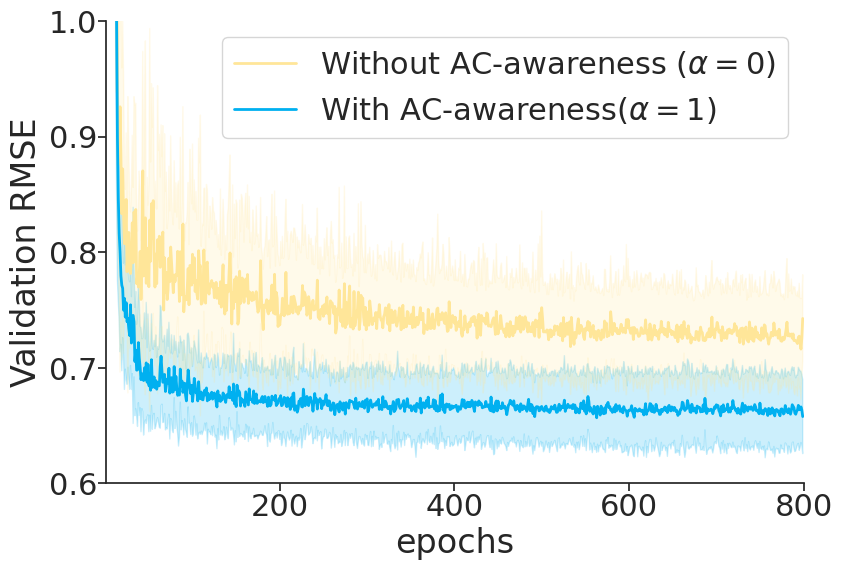

In [74]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'val_rmse'

n1 = r'With AC-awareness($\alpha=1$)'
n2 = r'Without AC-awareness ($\alpha = 0 $)'


dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Validation RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Validation_RMSE.svg', bbox_inches='tight', dpi=400) 

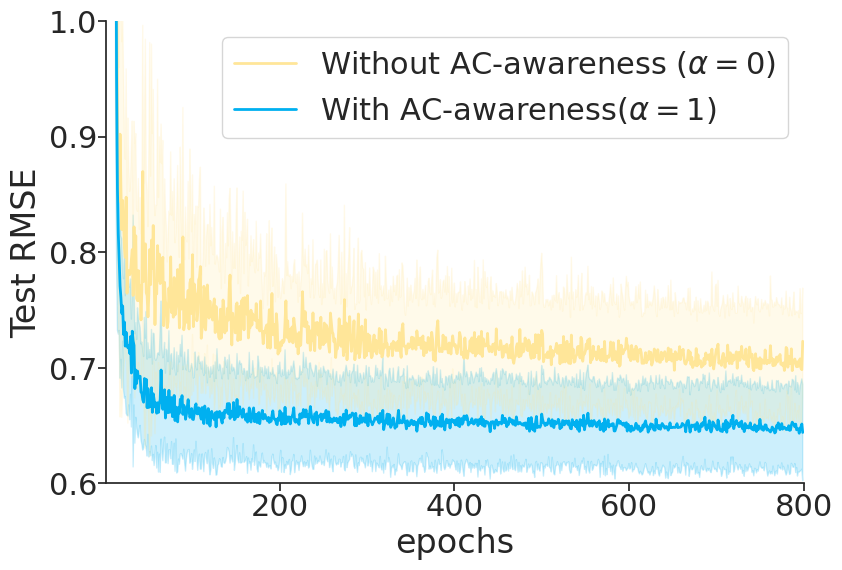

In [75]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'test_rmse'

n1 = r'With AC-awareness($\alpha=1$)'
n2 = r'Without AC-awareness ($\alpha = 0 $)'


dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Test RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Test_RMSE.svg' , bbox_inches='tight', dpi=400) 

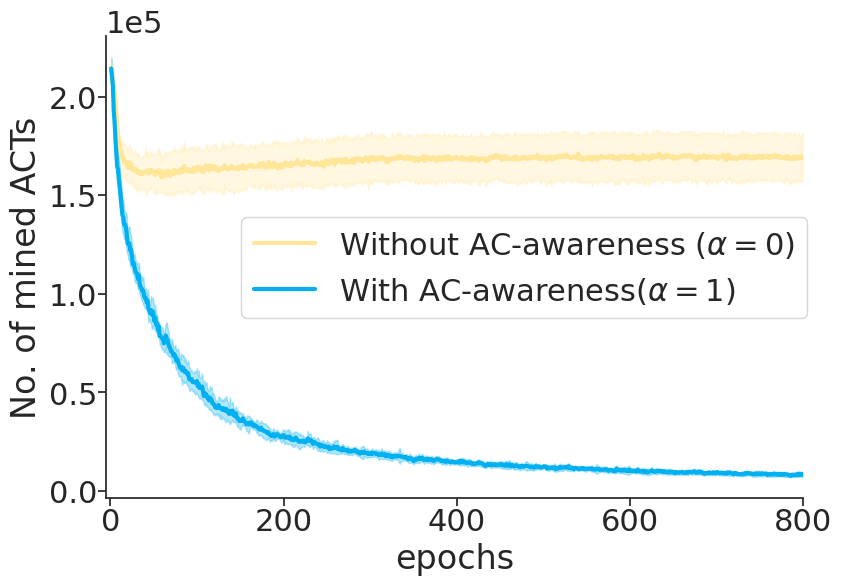

In [76]:
fig, ax = plt.subplots(figsize=(9, 6))


y = 'n_pos_triplets'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.legend(loc='center', bbox_to_anchor=(0.6, 0.5))

ax.spines[['right', 'top']].set_visible(False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel('No. of mined ACTs')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
ax.set_xlim(-5,800)


fig.savefig('./Number_of_mined_ACTs_during_training.svg' , bbox_inches='tight', dpi=400) 

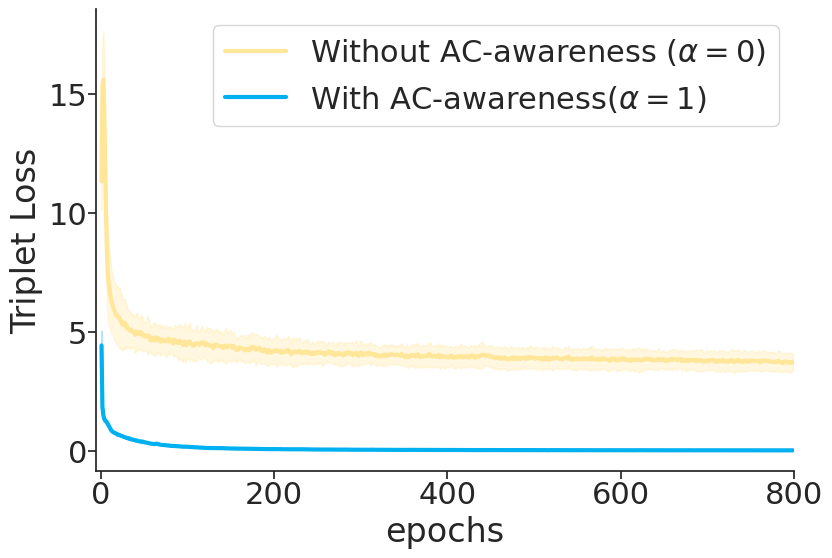

In [77]:
fig, ax = plt.subplots(figsize=(9, 6))
y = 'train_triplet_loss'
dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(-5,800)


ax.set_ylabel('Triplet Loss')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Triplet_loss_during_training.svg', bbox_inches='tight', dpi=400) 

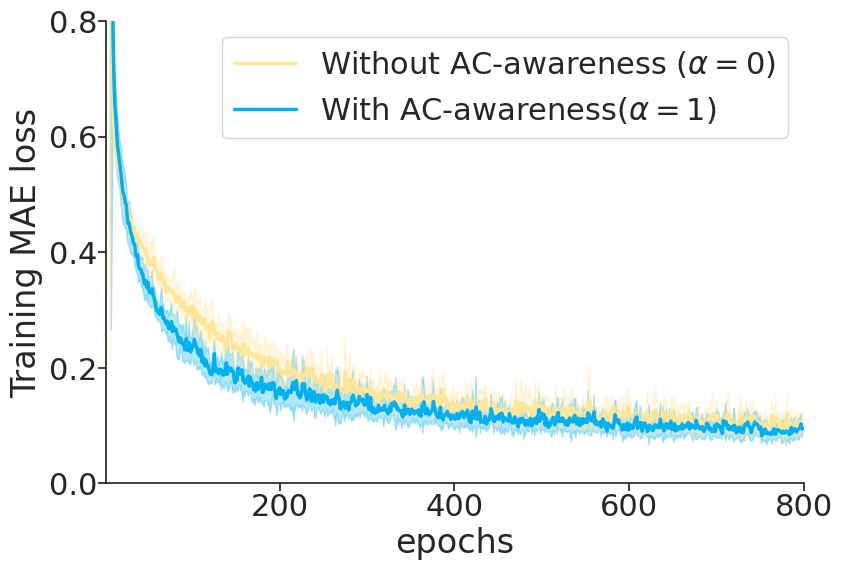

In [78]:
fig, ax = plt.subplots(figsize=(9, 6))

y = 'train_mae_loss'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2.5, ax=ax,color = colors, alpha =1)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)



ax.set_ylim(0.0, 0.8)
ax.spines[['right', 'top']].set_visible(False)


ax.set_ylabel('Training MAE loss')
ax.set_xlabel('epochs')

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Train_mae_los.svg', bbox_inches='tight', dpi=400) 